# A model of imperfect understanding of the income process

This notebook experiments multiple dimensions via which agents misspecify the model of income leading to following empirical patterns of subjective income risk

- Higher realizations corresponding to lower perceived risks 
- Older age corresponds to lower uncertainty 
- Cohort-specific uncertainty depending on the past realization of the income dispersion of the group 
- Certain kind of asymmetry in the effect of realization of shocks, i.e. positive shocks brings about lower uncertainty and higher reduces the uncerainty. 
- Interplay between income realizations and uncertainty, i.e. extrapolative from first moment to the second 

### A generic model of learning  


\begin{eqnarray}
y_{i,c,t} = \rho y_{i,c,t-1} + \epsilon_{i,c,t}
\end{eqnarray}

- persistence parameter is the same across cohort and inviduals. It is known by the modeler but not perfectly understood by the agents 
- the income shock is purely i.i.d., independent across individuals and time, namely 

\begin{eqnarray}
E(\epsilon_{i,c,t},\epsilon_{j,c,t}|y_{i,c,t-1}) = 0 \quad \forall i \neq j
\end{eqnarray}

and 

\begin{eqnarray}
E(\epsilon_{i,c,t},\epsilon_{i,c,t+k}|y_{i,t-1}) = 0 \quad \forall k >0
\end{eqnarray}

- individual $i$ learns about the income process by "running" a regression of the above model using a limited sample of experienced income realizations of herself from $0$ to $t$ and a subsample of people from the same cohort or the population. 

- when learning, however, the agent has no perfect understanding of the shock is i.i.d., instead, she thinks that her shock at time $t$ is either serially correlated or cross-sectionally correlated. The former represents the scenario where the agent thinks a purely one-period shock is actually more persistent than the truth. The later represents a scenario in which the agent thinks an entirely idiosyncratic shock is actually an aggregate one affecting all in the cohort. What's potentially interesting is that we could allow people's mis-interpretation to depend on the sign of the realized shock. The asymmetry of cross-sectional correlation bias could be driven by  people's asymmetric behavior attributing a bad luck to external causes while a good one to internal causes. The misinterpretation of time-serial correlation hinges on the people's degree of subjective optimism. A bad (good) luck will be interpreted as a more persistent (transitory) one by a pessimist but a transitory (persistent) one by an optimist. These mechanisms interact each other. The following

More formally, this implies the following by denoting $E_{i,t}$ as people's subjective perception of the model.

Serially correlation means 

\begin{eqnarray}
E_{i,t}(\epsilon_{i,c,t},\epsilon_{i,c,t+k}|y_{i,c,t-1}) \neq 0 \quad \forall \quad k 
\end{eqnarray}

Cross-sectional correlation means

\begin{eqnarray}
E_{i,t}(\epsilon_{i,c,t},\epsilon_{j,c,t+k}|y_{i,c,t-1}) \neq 0 \quad \forall i \neq j \text{ and } i, j \in c 
\end{eqnarray}

It is worth pointing out that so far, we have not introduced any model mis-specification that induces bias of the estimate of the persistence parameter $\rho$. But there is no any practical hurdle of doing that. For instance, we could allow the regressors to be subject to some measurement errors. Also, we could allow the past observations to enter the learning in a diminshing weight to capture the idea of memory decay, i.e. people overweight recent memories. In the baseline model, I omit these extensions in order to focus on the implication of the model mis-specification on the uncertainty about the parameter. 

In general, the variance of the coefficient estimate that takes into account the serial or cross-sectional correlation is higher than the one corresponding to the i.i.d. assumption. This will endogenously generate difference in individual's uncertainty about their future income prediction.  

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import numpy.linalg as lg

In [147]:
class ARProcess:
    def __init__(self,
                 ar_paras = np.array([0.97,0.1]),
                 N = 60):
        self.ar_paras = ar_paras
        self.rho = ar_paras[0]
        self.sigma = ar_paras[1]
        self.N = N 
        self.k = 1
        self.burn = 0.1
        self.n_sim = 60
        self.shock_type = 'iid'
        self.shock_type_perceived = 'iid'
        self.work_age = 15
             
# simulate individual time series and cross-sectional data 

    def Simulate(self):
        ar1 = self.ar_paras
        rho,sigma = ar1
        ma1 = np.array([1])
        N_burn = int(self.burn*self.N)
        N_long = self.N + N_burn
        simulated_data = np.empty(N_long)
        simulated_data[0] = 0.01
        if self.shock_type =='iid':
            shocks = sigma*np.random.randn(N_long)
        for i in range(N_long-1):
            simulated_data[i+1] = rho*simulated_data[i] + shocks[i+1]
        #AR_object1 = ArmaProcess(ar1,ma1)
        #simulated_data = AR_object1.generate_sample(nsample = self.N)
        self.simulated = simulated_data[N_burn:]
        return self.simulated 
    
    def SimulatePop(self):
        self.simulated_pop = np.empty([self.n_sim,self.N])
        for i in range(self.n_sim):
            self.simulated_pop[i,:] = self.Simulate()
        return self.simulated_pop
    
## learning based on a given sample 
    
    def LearnPara(self,
                  sample,
                  which = 1): 
        n_sim,N = sample.shape
        Y = np.asmatrix(sample[:,1:].flatten()).T
        X = np.asmatrix(sample[:,:-1].flatten()).T
        nobs = len(Y)
        model = sm.OLS(Y,X)
        rs = model.fit()
        #print(rs.summary())
        coeffs_est = rs.params
        self.rs_correct = rs
        self.errs = rs.resid.reshape(n_sim,N-1) ## residuals matrix 
        if self.shock_type_perceived == 'iid':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D = np.eye(nobs)*self.sigma**2
            self.D_est = np.eye(nobs)*self.sigma2_est
            xx = np.dot(X.T,X)
            ## regression coeffs 
            #coef_var_est0 = rs.bse**2  # using statsmodel package 
            coef_var_est1 = np.array(lg.inv(xx)*self.sigma2_est)  ## by hand 
            #coef_var_est2 = np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
            #                                     X.T),
            #                                     self.D_est),
            #                              X),
            #                       lg.inv(xx)
            #                      )) ## by general formula 
            self.coef_var_est = coef_var_est1
            
        if self.shock_type_perceived == 'cluster':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[:,j]*self.errs[:,j])),
                                       lg.inv(np.matrix(np.sum(sample[:,j]*self.errs[:,j]
                                                              )
                                                       )
                                             )
                                      ) for j in range(N-1)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            self.coef_var_est = coef_var_est2
            
        if self.shock_type_perceived == 'serial_correlate':
            self.sigma2_est = np.sum(self.errs**2)/(rs.nobs-1)
            self.D_est = np.sum([np.dot(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:])),
                                       lg.inv(np.matrix(np.sum(sample[i,:-1]*self.errs[i,:]
                                                              )
                                                       )
                                             )
                                      ) for i in range(n_sim)])
            xx = np.dot(X.T,X)
            ## regression coeffs 
            coef_var_est2 = (rs.nobs-1)/(rs.nobs-self.k)*N/(N-1)*np.array(np.dot(np.dot(np.dot(np.dot(lg.inv(xx),
                                                 X.T),
                                                 self.D_est),
                                          X),
                                   lg.inv(xx)
                                  )) ## by general formula 
            self.coef_var_est = coef_var_est2
        
        ## common estimate 
        self.paras_learned = coeffs_est
        
        ## forecast 
        self.var_predict_chg = self.sigma**2
        self.var_predict_chg_est = self.sigma2_est + sample[which,-1]**2*self.coef_var_est 
        # n_sim individual-specific var
        return self.paras_learned,self.coef_var_est,self.sigma2_est
    
## ages and experiences 

    def SimulateAgePop(self):
        minus_life = np.flip(np.arange(self.N))
        minus_life = np.expand_dims(minus_life,
                                    axis = 1).T
        minus_life_pop_sim = np.repeat(minus_life,
                                       self.n_sim,
                                       axis = 0) ## a matrix that is to be substracted to get the ages
        #age_pop_last = np.arange(self.n_sim)+20
        np.random.seed(2303)
        age_pop_last = np.random.choice(range(20,60),
                                        self.n_sim)
        age_pop_last = np.expand_dims(age_pop_last,
                                      axis =1) # a population with different ages 
        self.ages_pop_sim = age_pop_last - minus_life_pop_sim ## get the age 
        self.ages_pop_sim = np.where(self.ages_pop_sim < self.work_age, np.nan, self.ages_pop_sim)         
        return self.ages_pop_sim
    
    def Experience(self): ## age_pop is a simulated matrix with people in different ages. 
        sparse_pop = np.zeros(self.n_sim,self.N)
        for i in range(self.n_sim):
            for j in range(self.N):
                if j>=self.N-self.ages_pop_sim[i]:
                    sparse_pop[i,j] = 1 
    
    def LearnParafromExperience(self):
        
        ## simulate age 
        self.SimulateAgePop()
        
        ## locations 
        coeffs_est = np.empty([self.n_sim,self.N])
        sigma2_est = np.empty([self.n_sim,self.N])
        coef_vars_est = np.empty([self.n_sim,self.N])
        var_predict_chg_est = np.empty([self.n_sim,self.N])
        
        for i in range(self.n_sim):
            for j in range(self.N):
                if self.ages_pop_sim[i,j] > self.work_age:
                    st = np.min([idx for idx in range(j)]) ## begin of experience
                    ed = j  ## end of experience
                    sample_this = self.simulated_pop[:,st:ed]
                    if sample_this.shape[1] >= 2:  ## at least two observations 
                        self.LearnPara(sample = sample_this,
                                       which = i)
                        coeffs_est[i,j] = self.paras_learned
                        sigma2_est[i,j] = self.sigma2_est
                        coef_vars_est[i,j] = self.coef_var_est
                        var_predict_chg_est[i,j] = self.var_predict_chg_est
                else:
                    coeffs_est[i,j] =  np.nan
                    sigma2_est[i,j] = np.nan
                    coef_vars_est[i,j] = np.nan
                    var_predict_chg_est[i,j] = np.nan
        self.coeffs_est = coeffs_est
        self.sigma2s_est = sigma2_est
        self.coef_vars_est = coef_vars_est
        self.var_predict_chg_est = var_predict_chg_est
        return self.coeffs_est,self.coef_vars_est,self.sigma2s_est,self.var_predict_chg_est

In [148]:
## initialize an instance 

one = ARProcess()
simulated_data1 = one.Simulate()

In [149]:
ages = one.SimulateAgePop()

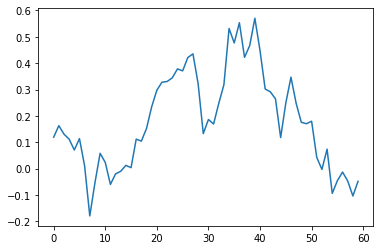

In [150]:
## simulate ar1 data 

plt.subplot(1,1,1)
plt.plot(simulated_data1)

Text(0.5, 1.0, 'Time series distribution')

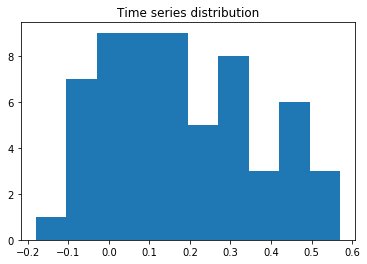

In [151]:
dist = plt.hist(simulated_data1)
plt.title('Time series distribution')

In [152]:
one.n_sim = 30
simulated_data_pop = one.SimulatePop()

Text(0.5, 1.0, 'Unconditional distribution')

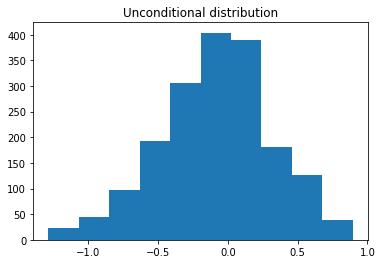

In [153]:
dist_pop = plt.hist(simulated_data_pop.flatten())
plt.title('Unconditional distribution')

## Perfect versus imperfect understanding without model mis-specification

- We compare the forecast uncertainty under perfect knowledge of the model parameters and imperfect understanding one below. 
- The former assumes the agent knows the true model parameters $\rho$ and $\sigma$. Therefore, the only uncertainty about next period income growth stems from the known uncertainty, the size of $\sigma^2$.
- The latter assumes the agents do not know the true parameter values, but make the estimates based on small samples.Therefore, the perceived income growth risks has two sources. The first is the uncertainty about parameter estimate $\rho$, represented by $\hat V_{i,\rho}$. The second component is the known uncertainty, the degree of which is based on the estimates of the risks, the estimate of $\widehat{\sigma}_i^2$. 

- There is no model misspecification in this scenario. The perceived risks of future income growth can be higher or lower than the true size of the risk.

In [154]:
## Estimate the model with the correctly specified model of i.i.d shock
one.LearnPara(sample = one.simulated_pop)

(array([0.97795085]), array([[3.4422956e-05]]), 0.009772475413488328)

In [155]:
## The true growth risk assumed in the model is 

one.var_predict_chg

0.010000000000000002

In [156]:
## The perceived growth risk is this
one.var_predict_chg_est

array([[0.0097725]])

## Correctly specified model versus mis-specificied model 

Estimate the model with the mis-specified model of clustered shocks while the truth is i.i.d



In [177]:
one.shock_type_perceived = 'cluster'
one.LearnPara(sample = one.simulated_pop)

(array([0.97795085]), array([[0.21134639]]), 0.009772475413488328)

The perceived growth risk under the model mis-specification is upward biased 

In [178]:
one.var_predict_chg_est

array([[0.00991452]])

Estimate the model with the mis-specified model of serially correlated shocks while the truth is i.i.d



In [179]:
one.shock_type_perceived = 'serial_correlate'
one.LearnPara(sample = one.simulated_pop)

(array([0.97795085]), array([[0.10746426]]), 0.009772475413488328)

The perceived growth risk under the model mis-specification is again upward biased compared to the true model

In [180]:
one.var_predict_chg_est

array([[0.0098447]])

## Age and perceived risk

In [181]:
one.shock_type_perceived = 'iid'
coeffs_est1,coef_vars_est,sigma2s_est,var_predict_chg_est1 = one.LearnParafromExperience()

In [182]:
ages = one.ages_pop_sim.flatten()
sigma2s = sigma2s_est.flatten()
coef_vars = coef_vars_est.flatten()
vars_predict_chg = var_predict_chg_est1.flatten()

Text(0, 0.5, 'var')

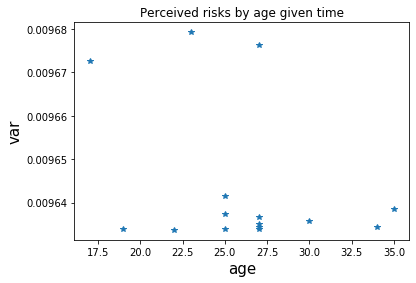

In [183]:
plt.plot(one.ages_pop_sim[:,35],
         var_predict_chg_est1[:,35],'*')
plt.title('Perceived risks by age given time')
plt.xlabel('age',fontsize = 15)
plt.ylabel('var',fontsize = 15)

Text(0, 0.5, 'var')

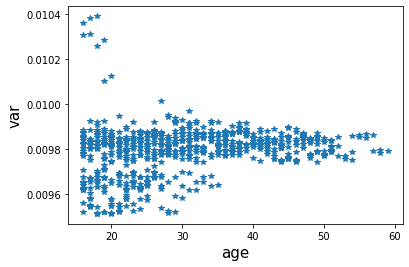

In [184]:
plt.plot(ages,vars_predict_chg,'*')
plt.xlabel('age',fontsize = 15)
plt.ylabel('var',fontsize = 15)

Text(0, 0.5, '$var_\\rho$')

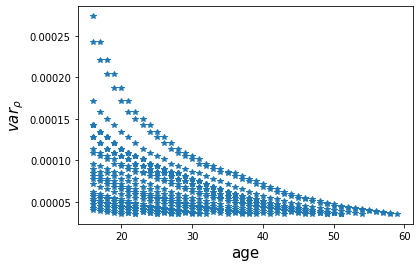

In [185]:
plt.plot(ages,coef_vars,'*')
plt.xlabel('age',fontsize = 15)
plt.ylabel(r'$var_\rho$',fontsize = 15)

Text(0, 0.5, '$\\hat \\sigma^2$')

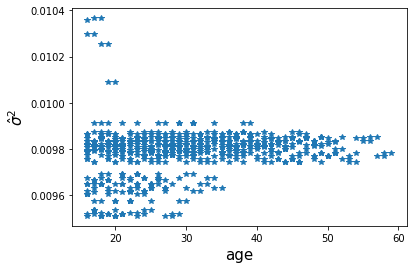

In [186]:
plt.plot(ages,sigma2s,'*')
plt.xlabel('age',fontsize = 15)
plt.ylabel(r'$\hat \sigma^2$',fontsize = 15)

## Experiences and risk

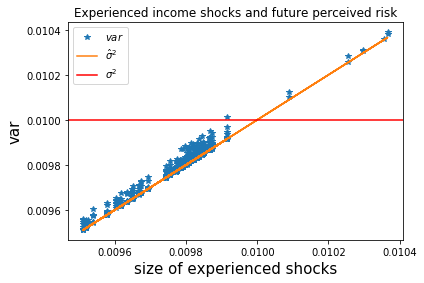

In [208]:
plt.plot(sigma2s,
         vars_predict_chg,'*',
         label = r'$var$')
plt.plot(sigma2s,
         sigma2s,'-',
         label = r'$\hat \sigma^2$')
plt.axhline(one.var_predict_chg,
            color ='red',
            label =r'$\sigma^2$')
plt.title('Experienced income shocks and future perceived risk')
plt.xlabel('size of experienced shocks',
           fontsize = 15)
plt.ylabel('var',fontsize = 15)
plt.legend(loc = 0)